In [115]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [116]:
arma_data = {'braidwood_covid':["./Output_Braidwood_2012_2021_DA/synthetic.csv", "../data/electricity_markets/PJM_braidwood/"],
              'braidwood_non_covid':["./Output_Braidwood_2012_2019_DA/synthetic.csv", "../data/electricity_markets/PJM_braidwood/"],
              'davis_besse':["./Output_davis_besse_2012_2021_DA/synthetic.csv", "../data/electricity_markets/PJM_davis_besse/"], 
              'ginna':["./Output_ginna_2012_2021_DA/synthetic.csv", "../data/electricity_markets/NYISO_ginna/"],
              'fitzpatrick':["./Output_fitzpatrick_2012_2021_DA/synthetic.csv", "../data/electricity_markets/NYISO_fitzpatrick/"],
              'nine_mile_point':["./Output_nine_mile_point_2012_2021_DA/synthetic.csv", "../data/electricity_markets/NYISO_nine_mile_point/"],
              'houston':["./Output_houston_2012_2021_DA/synthetic.csv", "../data/electricity_markets/ERCOT_houston/"], 
              'cooper': ["./Output_cooper_2014_2021_DA/synthetic.csv", "../data/electricity_markets/SPP_cooper/"]}


case = "cooper"


if case not in arma_data.keys():
  raise KeyError("{}, Case not in dictionary".format(case))
filename = arma_data[case][0]
data_dir = arma_data[case][1]

synthetic_df = pd.read_csv(filename)
tag = filename.split('/')[1][7:]
synthetic_df.head()
#only keep first 4 years of data
synthetic_df = synthetic_df[synthetic_df['Year']<=2021]
# Remove useless data
synthetic_df.drop(columns=['scaling', 'RAVEN_sample_ID','prefix', 'PointProbability', 'ProbabilityWeight'], inplace=True)
synthetic_df.rename({'price':'synthetic price'}, axis=1, inplace=True)
synthetic_df

,hour,Year,synthetic price
0,1,2014,25.445687
1,1,2015,17.644889
2,1,2016,14.123392
3,1,2017,-1.156663
4,1,2018,38.934365
...,...,...,...
315327,8760,2017,9.923050
315328,8760,2018,22.993560
315329,8760,2019,8.243399
315330,8760,2020,13.171489


In [117]:
# Get year list from synthetic data
years_list  = synthetic_df.Year.unique()
print(years_list)
files_names = os.listdir(data_dir)
li = []
for f in files_names: 
  if f.endswith('csv'):
    year = int(f.split('_')[0])
    if year in years_list:
      file = data_dir+f
      df = pd.read_csv(file)
      df['Year'] = [year for i in range(len(df))]
      li.append(df)
hist_df = pd.concat(li, axis=0, ignore_index=True)
hist_df.rename({'price':'historical price'}, axis=1,inplace=True)
hist_df

[2014 2015 2016 2017 2018 2019 2020 2021]


,historical price,hour,Year
0,22.4400,1,2014
1,19.1300,2,2014
2,21.2600,3,2014
3,21.4400,4,2014
4,20.3900,5,2014
...,...,...,...
70075,23.0785,8756,2015
70076,21.5296,8757,2015
70077,19.1573,8758,2015
70078,17.2926,8759,2015


Merge historical and synthetic data

In [118]:
sum_df = pd.merge(hist_df, synthetic_df, how='inner')
sum_df

,historical price,hour,Year,synthetic price
0,22.4400,1,2014,25.445687
1,19.1300,2,2014,25.060813
2,21.2600,3,2014,25.337309
3,21.4400,4,2014,24.256061
4,20.3900,5,2014,15.212759
...,...,...,...,...
70075,23.0785,8756,2015,25.175180
70076,21.5296,8757,2015,23.473053
70077,19.1573,8758,2015,15.545261
70078,17.2926,8759,2015,16.501364


In [119]:
# Statistic summary
temp_df = sum_df.drop(columns=['Year','hour'])
stats = dict(temp_df.describe())
#stats_df.append() = temp_df.kurtosis(axis=0)
for k,v in stats.items(): 
  stats[k] = dict(v)
#stats['historical price'] = dict(stats['historical price'])
# Add kurtosis
stats['historical price']['kurtosis'] = float(hist_df['historical price'].kurtosis(axis = 0))
stats['synthetic price']['kurtosis'] = float(synthetic_df['synthetic price'].kurtosis(axis = 0))
# Add skewness
stats['historical price']['skewness'] = float(hist_df['historical price'].skew(axis = 0))
stats['synthetic price']['skewness'] = float(synthetic_df['synthetic price'].skew(axis = 0))
stats_df = pd.DataFrame(stats)
stats_df.to_excel('ARMA_stats.xlsx',sheet_name=tag)
stats_df

,historical price,synthetic price
count,70080.000000,70080.000000
mean,25.821181,25.541419
std,110.320423,110.596605
min,-65.109300,-65.109300
25%,14.764500,14.391961
50%,19.299150,19.162884
75%,27.236725,27.231261
max,4230.957600,4230.957600
kurtosis,755.896282,750.062720
skewness,26.765592,26.609273


In [120]:
# Concatenate historic and synthetic prices with a tag
temp_hist = hist_df.drop(columns=['Year', 'hour']).rename({'historical price':'price'}, axis=1)
temp_synth = synthetic_df.drop(columns=['Year', 'hour']).rename({'synthetic price':'price'}, axis=1)
pieces = {'historical': temp_hist, 'synthetic':temp_synth}
prices_df = pd.concat(pieces, names=["type"])
prices_df = prices_df.reset_index(level=0)
prices_df

,type,price
0,historical,22.440000
1,historical,19.130000
2,historical,21.260000
3,historical,21.440000
4,historical,20.390000
...,...,...
315327,synthetic,9.923050
315328,synthetic,22.993560
315329,synthetic,8.243399
315330,synthetic,13.171489


4230.9576 27.236725 14.7645 -65.1093


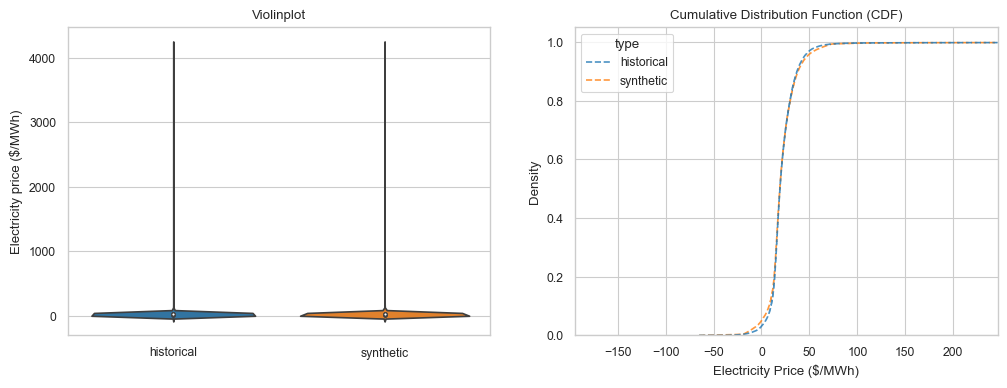

In [121]:
# Plot and save histograms and boxplots
fig, axes = plt.subplots(1,2,figsize =(12,4))

title = ' '.join(tag.split('_')).upper()+'\n Comparison of historical and synthetic data'
#fig.suptitle(title, y = 1.07)

mean  = stats['historical price']['mean']
price95 = 2*stats['historical price']['std']+mean
price05 = mean -2*stats['historical price']['std']
max_price = stats['historical price']['max']
quart1_price = stats['historical price']['25%']
min_price = stats['historical price']['min']
quart3_price = stats['historical price']['75%']
print(max_price, quart3_price, quart1_price, min_price)

sns.set_style('whitegrid')
sns.set_context('paper')

sns.violinplot(ax = axes[0],data=prices_df, x='type', y='price', alpha=0.8)
axes[0].set_title('Violinplot')
axes[0].set_ylabel('Electricity price ($/MWh)')
axes[0].set_xlabel('')

#sns.histplot(ax = axes[1,0], data=prices_df, x='price', hue='type', bins=5000, stat='density', common_norm=False)
#axes[1,0].set_title('Histogram')
#axes[1,0].set_xlabel('Electricity price ($/MWh)')
#axes[1,0].set_xlim(-25,200)

#sns.kdeplot(ax = axes[0,1], x='price', data=prices_df, hue='type', alpha= 0.5, multiple="stack",common_norm=False)
#axes[0,1].set_title('Kernel Density Function')
#axes[0,1].set_xlabel('Electricity Price ($/MWh)')
##axes[0,1].set_xlim(price05,price95)

sns.histplot(ax = axes[1], data=prices_df, x='price', hue='type', linestyle = "dashed", alpha=0.8,bins=len(prices_df), stat='density', element='step', fill=False,cumulative=True, common_norm=False)
axes[1].set_title('Cumulative Distribution Function (CDF)')
axes[1].set_xlabel('Electricity Price ($/MWh)')
axes[1].set_xlim(price05,price95)



#sns.histplot(ax = axes[2,0], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
#axes[2,0].set_title('CDF, Upper end tail zoom')
#axes[2,0].set_xlabel('Electricity Price ($/MWh)')
#axes[2,0].set_xlim(min_price,max(0.75*min_price, 1.25*min_price))

#sns.histplot(ax = axes[2,1], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
#axes[2,1].set_title('CDF, Lower end tail zoom')
#axes[2,1].set_xlabel('Electricity Price ($/MWh)')
#axes[2,1].set_xlim(0.99*max_price,max_price)

plt.grid(True)
fig.savefig(tag+'_comparison_plots.png')

